In [1]:
import sys
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import config

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.utils.multiclass import unique_labels

from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import re
import scipy



pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

def bold_max(df, dataset="", precision=2):
    """
    Return a Styler that bolds the column-wise maxima.

    Works with both:
    - numeric values
    - strings in the format '0.84 ± 0.02'

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with either numeric or 'mean ± std' strings.
    dataset : str
        A caption or title to display above the table.
    precision : int, default 2
        Number of decimals to show if numeric.
    """
    def is_string_with_std(val):
        return isinstance(val, str) and '±' in val
    
    def is_string_with_bracket(val):
        return isinstance(val, str) and '[' in val

    if df.applymap(is_string_with_std).all().all():
        # All cells are strings with ±
        def highlight_max(col):
            means = col.str.extract(r"(\d+\.\d+) ±")[0].astype(float)
            max_val = means.max()
            return ['font-weight: bold' if v == max_val else '' for v in means]

        return df.style.set_caption(f"Dataset: {dataset}").apply(highlight_max, axis=0)

    else:
        # Assume numeric DataFrame
        return (
            df.style
              .set_caption(f"Dataset: {dataset}")
              .format(f"{{:.{precision}f}}")
              .apply(lambda col: ['font-weight: bold' if v == col.max() else '' for v in col], axis=0)
        )

def clean_metadata(path_to_metadata):
    df = (
    (
        pd.read_csv(path_to_metadata)
        .rename(
            columns={
                "Anteojos o lentes de contacto": "glasses",
                "Años de escolaridad": "years_of_education",
                "MMSE / 30": "MMSE",
                "Reloj / 3": "clock_drawing_test",
                "Nro de participante": "suj",
                "Género": "sex",
                "Edad": "age",
                "Grupo": "group",
                "TMT A papel PB": "tmt_a_raw",
                "TMT B papel PB": "tmt_b_raw",
                "Digit Symbol pb": "digit_symbol_raw",
                "Span directo pb": "forward_digit_span_raw",
                "span inverso pb": "backward_digit_span_raw",
                "reloj": "clock_drawing_test",
                'TMT A (papel) Z': 'tmt_a_z',
                'TMT B (papel) Z': 'tmt_b_z',
                'Digit - symbol Z': 'digit_symbol_z',
                'Span directo Z': 'forward_digit_span_z',
                'Span inverso z': 'backward_digit_span_z'
            }
        )
        .replace("Caso ?", "Caso")
    )
    .drop([0, 1])
    .reset_index(drop=True) 
    )  # 0 and 1 are summary

    df.columns = [x.lower() for x in df.columns]
    print(df.columns)
    df = df.replace(",", ".", regex=True)
    df["sex"] = df["sex"].replace({"F": 1, "M": 0}).astype("Int64")
    df["group"] = df["group"].str.lower()
    df = df.replace("caso", "mci")
    df = df.replace("Suspendido", 300).replace("No logra", 300)  # 300 seconds it is the max time based on the literature
    df['digit_symbol_raw'] = df['digit_symbol_raw'].replace('no se lo administraron', np.nan).astype(float)
    df['digit_symbol_z'] = df['digit_symbol_z'].replace('pendiente', np.nan).astype(float)
    df = df.astype({"tmt_a_raw": float, "tmt_b_raw": float})
    df["suj"] = df["suj"].astype(int)
    return df

In [2]:
# my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-16_15-31-02/metrics.csv'
# 2025-05-26_12-12-40
my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-26_12-12-40/metrics.csv'
metadata_path = '../data/metadata/metadata.csv'
# eye_movements_path = '/home/gus/repos/tmt-analysis/src/eye_analysis/eye_movement_dataset.csv'
eye_movements_path = '/home/gus/repos/tmt-analysis/src/eye_analysis/eye_movement_dataset_2025-06-02-16-06-1748891726.csv'

# data/hand_analysis/2025-05-30_20-39-12/analysis.csv
newest_file_path = '../data/hand_analysis/2025-05-30_20-39-12/analysis.csv'

df_hand = pd.read_csv(newest_file_path)

Index(['suj', 'group', 'clasificación de caso',
       'comentario (tipo de caso o criterio de exclusión)', 'id participante',
       'fecha', 'hora', 'neuropsicol.', 'eyetracker', 'sex', 'age', 'glasses',
       'observaciones', 'mmse', 'mmse fallas', 'tmt_a_raw', 'tmt_a_z',
       'tmt_b_raw', 'tmt b papel errores', 'tmt_b_z', 'digit_symbol_raw',
       'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
       'backward_digit_span_raw', 'backward_digit_span_z',
       'clock_drawing_test', 'years_of_education'],
      dtype='object')


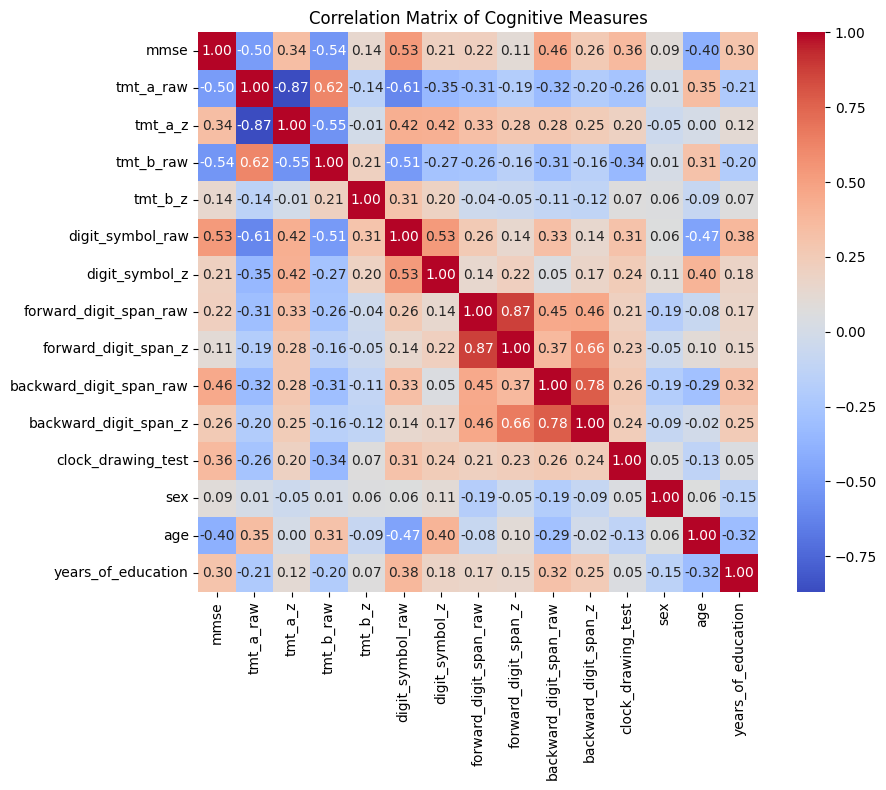

In [3]:
df_metadata = clean_metadata(metadata_path)

# Clean and convert appropriate columns to numeric
cognitive_columns = ['mmse','tmt_a_raw', 'tmt_a_z',
                    'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
                    'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
                    'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test',]

demographic_columns = ['sex', 'age','years_of_education']

group_column = ['group']

df_metadata_cognitive = df_metadata[['suj','group'] + demographic_columns + cognitive_columns].copy()

df_all = df_hand.merge(df_metadata_cognitive, left_on='subject_id', right_on='suj').rename(columns={"sex_y": "sex", "age_y": "age", "group_y": "group"})
keep_cols = [i for i in df_all.columns if "_x" not in i]
df_all = df_all[keep_cols]

# Compute correlation matrix
corr_matrix = df_metadata[cognitive_columns + demographic_columns].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cognitive Measures")
plt.tight_layout()
plt.show()

In [5]:
def sum_all_numbers(text):
    if pd.isna(text):
        return None
    numbers = re.findall(r'\d+\.?\d*', str(text))
    return sum(float(num) for num in numbers)


df_metadata['mmse fallas'].apply(sum_all_numbers)

df_metadata['mmse_mistakes_count'] = df_metadata['mmse fallas'].apply(sum_all_numbers)

In [6]:
df_metadata[['mmse', 'mmse fallas', 'mmse_mistakes_count']].head(40)

,mmse,mmse fallas,mmse_mistakes_count
0,30.0,--,0.0
1,28.0,-2 recuerdo,2.0
2,28.0,-2 atención,2.0
3,28.0,-1 atención. -1 recuerdo,2.0
4,25.0,-2 OT. -1 At. -1 rec. -1VC,5.0
5,29.0,-1 atencion,1.0
6,30.0,--,0.0
7,26.0,-3 OT. -1 recuerdo.,4.0
8,30.0,--,0.0
9,30.0,--,0.0


In [7]:
df_metadata

,suj,group,clasificación de caso,comentario (tipo de caso o criterio de exclusión),id participante,fecha,hora,neuropsicol.,eyetracker,sex,age,glasses,observaciones,mmse,mmse fallas,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt b papel errores,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,years_of_education,mmse_mistakes_count
0,1,control,NaN,*,946462,22/1/2024,14:30,Betsabé,Gus,1,52,-,No trajo los lentes para ver de cerca,30.0,--,32.00,0.37,47.00,NaN,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0,18.0,0.0
1,2,control,NaN,*,2684844,22/1/2024,15:00,Betsabé,Gus,0,78,Anteojos,NaN,28.0,-2 recuerdo,47.00,0.36,82.00,NaN,0.85,36.0,0.67,6.0,0.07,5.0,0.5,3.0,16.0,2.0
2,3,mci,DCL MD no amnesico,NaN,6305,22/1/2024,15:30,Laura,Gus,1,68,Anteojos,NaN,28.0,-2 atención,65.00,-0.38,107.00,NaN,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,12.0,2.0
3,4,mci,DCL MD no amnesico,NaN,2060316,22/1/2024,16:00,Laura,Gus,1,80,Anteojos,NaN,28.0,-1 atención. -1 recuerdo,55.00,0.03,109.00,NaN,0.36,38.0,1.33,5.0,-0.64,4.0,-0.21,3.0,15.0,2.0
4,5,mci,DCL MD no amnesico,NaN,4744,22/1/2024,16:30,Betsabé,Gus,1,87,Anteojos,NaN,25.0,-2 OT. -1 At. -1 rec. -1VC,63.00,-0.29,180.09,(2 errores),-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,DCL no amnesico,NaN,2302423,7/10/2024,13hs,Betsabe,Alejandro,1,75,anteojos,NaN,27.0,1 atenc. 2 recuerdo,38.90,0.69,93.70,2 errores,0.64,28.0,0.00,7.0,1.58,4.0,0.80,3.0,12.0,3.0
96,98,mci,DCL no amnesico,NaN,3104154,21/10/2024,13hs,Betsabe,Alejandro,1,70,anteojos,NaN,29.0,1 recuerdo,40.36,-0.63,140.00,4 errores,0.19,46.0,1.00,5.0,-0.08,4.0,0.80,3.0,15.0,1.0
97,99,mci,DCL no amnesico,NaN,2486596,21/10/2024,1:15:00 p.m.,Betsabe,Alejandro,1,71,NaN,NaN,29.0,1 recuerdo,51.80,0.16,78.30,NaN,0.92,42.0,0.67,6.0,0.75,6.0,2.80,3.0,18.0,1.0
98,100,control,NaN,NaN,22945,11/11/2024,13hs,Betsabe,Alejandro,0,76,anteojos,NaN,29.0,1 VC,50.42,0.22,69.40,-,1.08,40.0,0.67,8.0,2.42,5.0,1.80,3.0,18.0,1.0


In [8]:
z_cols = [col for col in df_metadata.columns if 'z' in col]

df_metadata[['suj', 'group', 'mmse'] + z_cols]

,suj,group,mmse,tmt_a_z,tmt_b_z,digit_symbol_z,forward_digit_span_z,backward_digit_span_z
0,1,control,30.0,0.37,1.36,0.00,-0.17,-0.60
1,2,control,28.0,0.36,0.85,0.67,0.07,0.5
2,3,mci,28.0,-0.38,0.40,0.33,0.64,0.21
3,4,mci,28.0,0.03,0.36,1.33,-0.64,-0.21
4,5,mci,25.0,-0.29,-0.92,0.00,-0.64,-0.93
...,...,...,...,...,...,...,...,...
95,97,mci,27.0,0.69,0.64,0.00,1.58,0.80
96,98,mci,29.0,-0.63,0.19,1.00,-0.08,0.80
97,99,mci,29.0,0.16,0.92,0.67,0.75,2.80
98,100,control,29.0,0.22,1.08,0.67,2.42,1.80


In [9]:

df_metadata[['suj'] + list(df_metadata.columns[13:-2])].drop(['mmse fallas', 'tmt b papel errores'], axis=1).to_csv("metadata_for_ml.csv", index=False)

In [10]:
min_age = 51
metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_control = metadata_control[metadata_control['age'] >= min_age]
metadata_mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
metadata_mci = metadata_mci[metadata_mci['age'] >= min_age]

for var in demographic_columns:
    if var == "sex":
        # Combine these lists into a 2x2 contingency table
        # Count occurrences of each category (1 = Female, 0 = Male) in each group
        mci_counts = Counter(metadata_mci["sex"])
        control_counts = Counter(metadata_control["sex"])

        # Create the contingency table
        contingency_table = [
            [mci_counts[1], control_counts[1]],  # Female counts  (mci and control)
            [mci_counts[0], control_counts[0]],  # Male counts (mci and control)
        ]
        # Perform Chi-square test
        chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
        print(f"chi2: {var}, p={p:.3f}")
        continue
    t_stat, p_value = scipy.stats.ttest_ind(
        metadata_mci[var], metadata_control[var], nan_policy="omit"
    )
    print(f"T-test: {var}, p={p_value:.5f}")


print(len(metadata_control))
print(len(metadata_mci))

chi2: sex, p=0.672
T-test: age, p=0.09681
T-test: years_of_education, p=0.23728
42
55


In [11]:
# 1. Filter by validity, age, and minimum number of trials
min_age = 56
min_number_of_trials_by_type = 1
only_ratio = False
only_part_b = False

df = df_all.copy()
print("Initial unique subjects:", df['subject_id'].nunique())

df_valid = df[df["is_valid"]]
print("After filtering valid trials:", df_valid['subject_id'].nunique())

df_valid = df_valid[df_valid['age'] >= min_age]
print(f"After filtering by age >= {min_age}:", df_valid['subject_id'].nunique())

# Keep subjects with at least one valid PART_A and PART_B trial
valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

eligible_subjects = valid_counts[
    (valid_counts.get('PART_A', 0) >= min_number_of_trials_by_type) & 
    (valid_counts.get('PART_B', 0) >= min_number_of_trials_by_type)
].index

df_valid = df_valid[df_valid['subject_id'].isin(eligible_subjects)]
print("After filtering by min number of trials:", df_valid['subject_id'].nunique())

# 2. Pivot digital variables
digital_tmt_vars = [
       'rt','total_distance', 'non_cut_correct_targets_touches', 'non_cut_zigzag_amplitude', 'non_cut_rt', 
       'mean_speed', 'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
       'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions', 
       'total_hesitations', 'average_duration',
       'max_duration','zigzag_amplitude', 'distance_difference_from_ideal', 
       'area_difference_from_ideal', 'intra_target_time', 'inter_target_time'
]

df_digital_tmt = df_valid.pivot_table(
    index='subject_id',
    columns='trial_type',
    values=digital_tmt_vars
)

# Flatten column names (e.g., mean_speed_PART_A)
df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]

# 3. Compute B/A ratios
part_a_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_A')]
part_b_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_B')]
common_vars = [col.replace('_PART_A', '') for col in part_a_cols if f"{col.replace('_PART_A', '')}_PART_B" in part_b_cols]

for var in common_vars:
    df_digital_tmt[f"{var}_B_A_ratio"] = df_digital_tmt[f"{var}_PART_B"] / df_digital_tmt[f"{var}_PART_A"]

df_digital_tmt.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. Add validity percentage
df_grouped = df_valid.groupby(['subject_id', 'trial_type'])['is_valid'].sum().unstack()
df_grouped.columns = ['is_valid_sum_A', 'is_valid_sum_B']
df_grouped['is_valid_sum_A'] = (df_grouped['is_valid_sum_A'] / 10) * 100
df_grouped['is_valid_sum_B'] = (df_grouped['is_valid_sum_B'] / 10) * 100

df_digital_tmt = df_digital_tmt.merge(df_grouped, left_index=True, right_index=True)

# 5. Merge with cognitive metadata
df_digital_tmt = df_digital_tmt.reset_index().rename(columns={'subject_id': 'suj'})

df_digital_tmt_with_target = df_digital_tmt.merge(
    df_metadata_cognitive[['suj', 'group']], on='suj', validate='one_to_one'
).set_index('suj')

df_digital_tmt_with_target['group'] = df_digital_tmt_with_target['group'].str.replace('mci', '1').replace('control', '0').astype(int)

# 6. Demographic data
dataset_big = df_digital_tmt_with_target.index.tolist()

demographic_df = df_metadata_cognitive.loc[
    df_metadata_cognitive['suj'].isin(dataset_big),
    ['suj', 'sex', 'age', 'years_of_education', 'group']
].copy()

demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
demographic_df.set_index('suj', inplace=True)

# 7. Non-digital data
non_digital_vars = ['mmse', 'tmt_a_raw','tmt_a_z', 'tmt_b_raw', 'tmt_b_z', 
                    'digit_symbol_raw', 'digit_symbol_z','forward_digit_span_raw', 
                    'forward_digit_span_z', 'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test']

non_digital_df = df_metadata_cognitive.loc[
    df_metadata_cognitive['suj'].isin(dataset_big),
    ['suj'] + non_digital_vars + ['group']
].copy()

non_digital_df['group'] = non_digital_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
non_digital_df.set_index('suj', inplace=True)

# 8. Eye movement data
df_eye = pd.read_csv(eye_movements_path)
df_eye['group'] = df_eye['group'].str.replace('MCI', '1').replace('control', '0').astype(int)

df_digital_hand_and_eye = df_digital_tmt_with_target.reset_index().merge(
    df_eye, on='suj', validate='one_to_one', suffixes=('', '_eye')
).set_index('suj')

df_digital_hand_and_eye['group'] = df_digital_hand_and_eye['group']  # keep consistent naming
df_digital_hand_and_eye.drop(columns=['group_eye'], inplace=True, errors='ignore')
cols =[col for col in df_digital_hand_and_eye.columns if col != 'group'] +  ['group'] 
df_digital_hand_and_eye = df_digital_hand_and_eye[cols]

# 9. Optional: filter to only PART_B variables
if only_part_b:
    cols_b = [col for col in df_digital_tmt_with_target.columns if col.endswith(('B', 'b'))]
    df_digital_tmt_with_target = df_digital_tmt_with_target[cols_b + ['group']]
    df_digital_hand_and_eye = df_digital_hand_and_eye[cols_b + ['group']]

if only_ratio:
    print("ONLY RATIO")
    cols_ratio = [i for i in df_digital_tmt_with_target.columns if '_ratio' in i]
    df_digital_tmt_with_target = df_digital_tmt_with_target[cols_ratio + ['group']]
    print(df_digital_tmt_with_target.columns)
    df_digital_hand_and_eye = df_digital_hand_and_eye[cols_ratio + ['group']]


digital_test_less_subjects = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index]
non_digital_test_less_subjects = non_digital_df.loc[df_digital_hand_and_eye.index]

processed_path = '../data/processed/'
# Final checks
print(df_digital_tmt_with_target['group'].value_counts())
df_digital_tmt_with_target.to_csv(processed_path + 'df_digital_tmt_with_target.csv', index_label='suj')
print(demographic_df['group'].value_counts())
demographic_df.to_csv(processed_path + 'demographic_df.csv', index_label='suj')
print(non_digital_df['group'].value_counts())
non_digital_df.to_csv(processed_path + 'non_digital_df.csv', index_label='suj')
print(df_digital_hand_and_eye['group'].value_counts())
df_digital_hand_and_eye.to_csv(processed_path + 'df_digital_hand_and_eye.csv', index_label='suj')
print(digital_test_less_subjects['group'].value_counts())
digital_test_less_subjects.to_csv(processed_path + 'digital_test_less_subjects.csv', index_label='suj')
print(non_digital_test_less_subjects['group'].value_counts())
non_digital_test_less_subjects.to_csv(processed_path + 'non_digital_test_less_subjects.csv', index_label='suj')

Initial unique subjects: 92
After filtering valid trials: 86
After filtering by age >= 56: 79
After filtering by min number of trials: 74
group
1    41
0    33
Name: count, dtype: int64
group
1    41
0    33
Name: count, dtype: int64
group
1    41
0    33
Name: count, dtype: int64
group
1    29
0    23
Name: count, dtype: int64
group
1    29
0    23
Name: count, dtype: int64
group
1    29
0    23
Name: count, dtype: int64


In [11]:
z_columns = [i for i in df_metadata_cognitive.columns if 'z' in i]

df_metadata_cognitive_z = df_metadata_cognitive[['suj'] + z_columns]

df_metadata_cognitive_z

,suj,tmt_a_z,tmt_b_z,digit_symbol_z,forward_digit_span_z,backward_digit_span_z
1,2,0.36,0.85,0.67,0.07,0.5
2,3,-0.38,0.40,0.33,0.64,0.21
4,5,-0.29,-0.92,0.00,-0.64,-0.93
5,6,0.02,1.25,0.33,0.79,0.5
7,8,0.24,1.16,2.67,0.07,-0.21
...,...,...,...,...,...,...
95,97,0.69,0.64,0.00,1.58,0.80
96,98,-0.63,0.19,1.00,-0.08,0.80
97,99,0.16,0.92,0.67,0.75,2.80
98,100,0.22,1.08,0.67,2.42,1.80


In [12]:
# Excluir 'suj' y asegurarse que las columnas sean numéricas
z_only = df_metadata_cognitive_z.drop(columns='suj').apply(pd.to_numeric, errors='coerce')

# Contar cuántos valores por fila tienen |z| >= 1.5
count_extreme = (z_only.abs() >= 1.5).sum(axis=1)

# Crear la nueva columna booleana
df_metadata_cognitive_z['has_2_or_more_extreme'] = count_extreme >= 2
df_metadata_cognitive_z[df_metadata_cognitive_z['has_2_or_more_extreme']]

/tmp/ipykernel_533241/2799952214.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metadata_cognitive_z['has_2_or_more_extreme'] = count_extreme >= 2


,suj,tmt_a_z,tmt_b_z,digit_symbol_z,forward_digit_span_z,backward_digit_span_z,has_2_or_more_extreme
8,9,-0.50,300,2.33,-0.69,-1,True
12,13,-0.13,-1.75,1.67,-1.5,-1.21,True
27,28,-1.64,-3.16,-1.00,-0.64,-0.21,True
50,51,-1.93,-3.82,1.67,2.7,1.5,True
52,53,-1.76,-2.94,-0.66,-0.64,-0.21,True
75,77,-1.89,-2.04,0.00,-1.36,-0.21,True
86,88,-1.68,-1.55,1.67,0.08,0.80,True
91,93,0.97,0.00,1.00,2.42,2.80,True
98,100,0.22,1.08,0.67,2.42,1.80,True


In [29]:
[config.SUBJECT_GROUP[i] for i in df_metadata_cognitive_z[df_metadata_cognitive_z['has_2_or_more_extreme']]['suj']]

['MCI', 'MCI', 'control', 'MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'control']

In [15]:
min_age = 56
metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_control = metadata_control[metadata_control['age'] >= min_age]
metadata_mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
metadata_mci = metadata_mci[metadata_mci['age'] >= min_age]

for var in demographic_columns:
    if var == "sex":
        # Combine these lists into a 2x2 contingency table
        # Count occurrences of each category (1 = Female, 0 = Male) in each group
        mci_counts = Counter(metadata_mci["sex"])
        control_counts = Counter(metadata_control["sex"])

        # Create the contingency table
        contingency_table = [
            [mci_counts[1], control_counts[1]],  # Female counts  (mci and control)
            [mci_counts[0], control_counts[0]],  # Male counts (mci and control)
        ]
        # Perform Chi-square test
        chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
        print(f"chi2: {var}, p={p:.3f}")
        continue
    t_stat, p_value = scipy.stats.ttest_ind(
        metadata_mci[var], metadata_control[var], nan_policy="omit"
    )
    print(f"T-test: {var}, p={p_value:.5f}")


print(len(metadata_control))
print(len(metadata_mci))

chi2: sex, p=1.000
T-test: age, p=0.07772
T-test: years_of_education, p=0.68281
33
41


In [21]:
from scipy.stats import fisher_exact

# Construct contingency table
table = [[25, 30],  # Female counts: control, MCI
         [8, 11]]   # Male counts: control, MCI

oddsratio, p_value = fisher_exact(table)
print(f"Fisher's Exact Test p-value: {p_value:.4f}")


Fisher's Exact Test p-value: 1.0000


In [17]:
metadata_control['sex'].value_counts()

sex
1    25
0     8
Name: count, dtype: Int64

In [18]:
metadata_mci['sex'].value_counts()

sex
1    30
0    11
Name: count, dtype: Int64

In [22]:
import pandas as pd

# Function to get mean ± SD formatted
def mean_std(series):
    return f"{series.mean():.2f} ± {series.std():.2f}"

# Prepare rows
summary_data = {
    "Variable": [],
    "Control": [],
    "MCI": []
}

# Age
summary_data["Variable"].append("Age")
summary_data["Control"].append(mean_std(metadata_control["age"]))
summary_data["MCI"].append(mean_std(metadata_mci["age"]))

# Years of education
summary_data["Variable"].append("Years of education")
summary_data["Control"].append(mean_std(metadata_control["years_of_education"]))
summary_data["MCI"].append(mean_std(metadata_mci["years_of_education"]))

# Sex (Female / Male counts)
control_f = (metadata_control["sex"] == 1).sum()
control_m = (metadata_control["sex"] == 0).sum()
mci_f = (metadata_mci["sex"] == 1).sum()
mci_m = (metadata_mci["sex"] == 0).sum()

summary_data["Variable"].append("Sex (F / M)")
summary_data["Control"].append(f"{control_f} / {control_m}")
summary_data["MCI"].append(f"{mci_f} / {mci_m}")

# Convert to DataFrame and show
summary_df = pd.DataFrame(summary_data)

summary_df

,Variable,Control,MCI
0,Age,72.70 ± 8.36,75.95 ± 7.27
1,Years of education,14.15 ± 2.84,13.83 ± 3.72
2,Sex (F / M),25 / 8,30 / 11


In [26]:
metadata_mci["age"].mean()

75.95121951219512

## Checking variables with tSNE

In [ ]:
X = df_digital_tmt_with_target.iloc[:, :-1]

# Assuming X is your DataFrame with only numeric features
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)

# Convert to DataFrame for plotting
tsne_df = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'], index=X.index)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'])
for i in tsne_df.index:
    plt.text(tsne_df.loc[i, 'TSNE1'], tsne_df.loc[i, 'TSNE2'], str(i), fontsize=8)
plt.title("t-SNE Embedding of Digital TMT Features")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.grid(True)
plt.show()


In [ ]:
# 1. Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)

# 2. Convert to DataFrame
tsne_df = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'], index=X.index)

# 3. Map group labels
tsne_df['group'] = tsne_df.index.map(df_digital_tmt_with_target['group'].to_dict())
tsne_df['group'] = tsne_df['group'].replace('amnesic', 'MCI') 

# 4. Plot with color by group
plt.figure(figsize=(10, 7))
for group, df_group in tsne_df.groupby('group'):
    plt.scatter(df_group['TSNE1'], df_group['TSNE2'], label=group, s=50)

plt.title("t-SNE of TMT Features Colored by Group")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title='Group')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
for variable in ['sex', 'age', 'years_of_education']:
    var_dict = dict(zip(demographic_df.reset_index()['suj'], demographic_df.reset_index()[variable]))

    # 1. Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_embedded = tsne.fit_transform(X)

    # 2. Convert to DataFrame
    tsne_df = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'], index=X.index)

    # 3. Map age
    tsne_df['age'] = tsne_df.index.map(var_dict)

    # 4. Plot with continuous colormap
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        tsne_df['TSNE1'],
        tsne_df['TSNE2'],
        c=tsne_df['age'],
        cmap='viridis', 
        s=60,
        edgecolor='k'
    )
    plt.colorbar(scatter, label='Age')
    plt.title(f"t-SNE of TMT Features Colored by {variable}")
    plt.xlabel("TSNE1")
    plt.ylabel("TSNE2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
df_digital_tmt_with_target.shape

## Modelling

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.metrics import roc_auc_score



# df_digital_tmt_with_target
# demographic_df
# non_digital_df
# df_digital_hand_and_eye
# digital_test_less_subjects
# non_digital_test_less_subjects


# Setup
k_select = 20
X = df_digital_tmt_with_target.drop(columns='group')
y = df_digital_tmt_with_target['group']

# Pipelines
pipeline_with_pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # or 'median' depending on your data

    # ('select', SelectKBest(score_func=f_classif, k=k_select)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipeline_no_pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # or 'median' depending on your data
    # ('select', SelectKBest(score_func=f_classif, k=k_select)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, solver='liblinear'))
])

def loocv_collect_predictions(pipeline, X, y):
    loo = LeaveOneOut()
    
    y_true_all = []
    y_pred_all = []
    y_pred_proba_all = []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Skip folds with only one class in training
        if len(np.unique(y_train)) < 2:
            continue

        model = clone(pipeline)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)[0]
        y_proba = model.predict_proba(X_test)[0, 1]

        y_true_all.append(y_test.values[0])
        y_pred_all.append(y_pred)
        y_pred_proba_all.append(y_proba)

    return np.array(y_true_all), np.array(y_pred_all), np.array(y_pred_proba_all)

# Run both pipelines
y_true_pca, y_pred_pca, y_proba_pca = loocv_collect_predictions(pipeline_with_pca, X, y)
y_true_nopca, y_pred_nopca, y_proba_nopca = loocv_collect_predictions(pipeline_no_pca, X, y)

# Calculate AUC once
auc_pca = roc_auc_score(y_true_pca, y_proba_pca)
auc_nopca = roc_auc_score(y_true_nopca, y_proba_nopca)

print(f"✅ Final AUC with PCA:    {auc_pca:.3f}")
print(f"✅ Final AUC without PCA: {auc_nopca:.3f}")


In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import clone

import pandas as pd
k_select = 20

# Prepare data
X = df_digital_tmt_with_target.drop(columns='group')
y = df_digital_tmt_with_target['group']

# CV setup
loo = LeaveOneOut()

# Base pipeline
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=k_select)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

selected_features_per_fold = []

# Loop through each LOOCV split
for train_idx, test_idx in loo.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    
    # Clone pipeline to avoid state sharing
    pipe = clone(pipeline)
    pipe.fit(X_train, y_train)
    
    # Get selected features for this fold
    selector = pipe.named_steps['select']
    selected_mask = selector.get_support()
    selected_features = X.columns[selected_mask].tolist()
    selected_features_per_fold.append(selected_features)

# View summary
for i, feat in enumerate(selected_features_per_fold[:k_select]):
    print(f"Fold {i+1}: {feat}")


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Data
X = df_digital_tmt_with_target.drop(columns='group')
y = df_digital_tmt_with_target['group']

# Pipeline
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),  # You can tune this too if needed
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Parameter grid: test different values of k
param_grid = {
    'select__k': list(range(2, min(21, X.shape[1] + 1)))  # Try k from 2 up to 20 or total features
}

# Stratified K-Fold CV to maintain class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV setup
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid.fit(X, y)

# Show best results
print(f"✅ Best k: {grid.best_params_['select__k']}")
print(f"📈 Best AUC: {grid.best_score_:.3f}")


In [ ]:
# main_columns =  ['rt_PART_A','rt_PART_B', 'is_valid_sum_A', 'is_valid_sum_B', 
#                  'non_cut_zigzag_amplitude_PART_B','non_cut_correct_targets_touches_PART_A', 
#                  'non_cut_correct_targets_touches_PART_B', 'group']

# df_digital_tmt_with_target = df_digital_tmt_with_target[main_columns]
# dataset = 'demographic'
# print('dataset:', dataset)
# n_splits = 4
# print('n_splits:', n_splits)
# n_importances = 15

# # Assuming df_digital_tmt_with_target is already defined
# match dataset:
#     case 'demographic':
#         n_importances = 3
#         X = demographic_df.iloc[:, :-1].values
#         y = demographic_df.iloc[:, -1].values
#         feature_names = demographic_df.columns[:-1]
#     case 'non_digital_tests':
#         X = non_digital_df.iloc[:, :-1].values
#         y = non_digital_df.iloc[:, -1].values
#         feature_names = non_digital_df.columns[:-1]
#     case 'digital_test':
#         X = df_digital_tmt_with_target.iloc[:, :-1].values
#         y = df_digital_tmt_with_target.iloc[:, -1].values
#         feature_names = df_digital_tmt_with_target.columns[:-1]
#     case 'digital_test_less_subjects': # less subjects
#         X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
#         y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
#         feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
#     case 'hand_and_eye':
#         X = df_digital_hand_and_eye.iloc[:, :-1].values
#         y = df_digital_hand_and_eye.iloc[:, -1].values
#         feature_names = df_digital_hand_and_eye.columns[:-1]
#     case 'only_eye':
#         X = df_eye.iloc[:, :-1].values
#         y = df_eye.iloc[:, -1].values
#         feature_names = df_eye.columns[:-1]

#     case _:
#         raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests`, `digital_test`,`df_digital_hand_and_eye` o `digital_test_less_subjects`]')



# # Print class distribution
# unique, counts = np.unique(y, return_counts=True)
# print("Class distribution:", dict(zip(unique, counts)))
# print("n_importances:", n_importances)

# # Define parameter grids
# param_grids = {
#     "RandomForestClassifier": {
#         # "feature_selection__n_features_to_select": [10, 15, 20],   
#         "classifier__n_estimators": [100, 500, 700, 1000],
#         "classifier__max_depth": [None, 10, 20, 30]
#     },
#     "SVC": {
#         # "feature_selection__n_features_to_select": [10, 15, 20],
#         "classifier__C": [0.1, 1, 10],
#         "classifier__kernel": ['linear', 'rbf']
#     },
#     "LogisticRegression": {
#         # "feature_selection__n_features_to_select": [10, 15, 20],
#         "classifier__C": [0.1, 1, 10],
#         "classifier__penalty": ['l2']
#     },
#     "XGBClassifier": {
#         # "feature_selection__n_features_to_select": [10, 15, 20],
#         "classifier__n_estimators": [100, 300],
#         "classifier__max_depth": [3, 5],
#         "classifier__learning_rate": [0.05, 0.1]
#     }
# }

# # Define models to evaluate
# models = [
#     RandomForestClassifier(random_state=42),
#     SVC(random_state=42, probability=True),
#     LogisticRegression(max_iter=1000, random_state=42),
#     xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
# ]

# # Set up outer CV
# outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=400)
# mean_fpr = np.linspace(0, 1, 100)

# # Create a DataFrame to store all metrics for all models
# all_metrics_df = pd.DataFrame(columns=[
#     'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
#     'recall', 'f1', 'auc', 'specificity'
# ])


# # Perform nested CV for each model
# for model in models:
#     fig, ax = plt.subplots(figsize=(6, 6))
#     model_name = model.__class__.__name__
#     print(f"\n🧪 Nested CV for: {model_name}")
#     importances_added = False  # Prevents printing for every fold

    
#     # Results for this model
#     tprs = []
#     aucs = []
#     best_params_list = []
#     selected_features = []
    
#     # Reset feature importance counts for this model
#     feature_importance_counts = {name: 0 for name in feature_names}
    
#     # Metrics for this model
#     fold_metrics = []
    
    
#     all_y_true = []
#     all_y_pred = []

#     best_models = []

    
#     # Outer CV loop
#     for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]

        
#         pipeline = Pipeline([
#             ('imputer', SimpleImputer(strategy='mean')),
#             ('scaler', StandardScaler()),
#             # ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
#             #                          n_features_to_select=n_importances)),
#             ('classifier', model)
#         ])
        
#         # Set up grid search with inner CV
#         param_grid = param_grids.get(model_name, {})
        
#         # Use AUC as the primary scoring metric for optimization
#         grid = GridSearchCV(
#             pipeline,
#             param_grid=param_grid,
#             cv=3,  # inner CV
#             scoring='roc_auc',
#             n_jobs=-1,
#             verbose=1  # Show progress
#         )
        
#         # Train on the current fold
#         grid.fit(X_train, y_train)
        
#         # Store best parameters
#         best_params_list.append(grid.best_params_)
        
#         # Get the best model from GridSearchCV
#         best_model = grid.best_estimator_
#         best_models.append(best_model)

#         # print("Best n_features_to_select:",
#         #       grid.best_params_["feature_selection__n_features_to_select"])
    

#         # Compute and plot feature importances for all models using permutation importance
#         if not importances_added:
#             print(f"\n🔍 Feature importances for {model_name} (using permutation importance):")

#             # Permutation importance works with any fitted estimator
#             result = permutation_importance(
#                 best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
#             )
#             sorted_idx = result.importances_mean.argsort()[::-1][:n_importances]
#             top_feature_names = np.array(feature_names)[sorted_idx]
#             top_importances = result.importances_mean[sorted_idx]

#             # Print importances
#             for i, (name, imp) in enumerate(zip(top_feature_names, top_importances), 1):
#                 print(f"{i}. {name}: {imp:.4f}")

#             # Plot
#             fig1, ax1 = plt.subplots(figsize=(10, 6))
#             ax1.barh(range(len(top_importances)), top_importances[::-1], align='center')
#             ax1.set_yticks(range(len(top_importances)), top_feature_names[::-1])
#             ax1.set_xlabel("Permutation Importance")
#             ax1.set_title(f"Top {n_importances} Feature Importances - {model_name}")
#             plt.tight_layout()
#             # plt.show()

#             importances_added = True  # Only print once per model

      
#         # # Track selected features
#         # feature_selector = best_model.named_steps['feature_selection']
#         # selected_mask = feature_selector.support_
#         # fold_selected_features = feature_names[selected_mask]
#         # selected_features.append(fold_selected_features)
        
#         # # Update feature importance counts
#         # for feature in fold_selected_features:
#         #     feature_importance_counts[feature] += 1
        
#         # Generate ROC curve
#         viz = RocCurveDisplay.from_estimator(
#             best_model,
#             X_test,
#             y_test,
#             name=f"ROC fold {fold}",
#             alpha=0.3,
#             lw=1,
#             ax=ax,
#             plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
#         )
        
#         # Get predicted probabilities and classes
#         y_pred_proba = best_model.predict_proba(X_test)[:, 1]
#         y_pred = best_model.predict(X_test)

#         all_y_true.extend(y_test)
#         all_y_pred.extend(y_pred)

        
#         # Calculate various metrics
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#         specificity = tn / (tn + fp)
        
#         metrics = {
#             'model': model_name,
#             'fold': fold,
#             'accuracy': accuracy_score(y_test, y_pred),
#             'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
#             'precision': precision_score(y_test, y_pred),
#             'recall': recall_score(y_test, y_pred),
#             'f1': f1_score(y_test, y_pred),
#             'auc': roc_auc_score(y_test, y_pred_proba),
#             'y_test': y_test,
#             'y_pred_proba': y_pred_proba,
#             'specificity': specificity
#         }
        
#         fold_metrics.append(metrics)
#         all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        
#         # Interpolate TPR for mean ROC
#         interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
#         interp_tpr[0] = 0.0
#         tprs.append(interp_tpr)
#         aucs.append(viz.roc_auc)
    
#     # Calculate mean ROC
#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)
    
#     # Plot mean ROC
#     ax.plot(mean_fpr, mean_tpr, color="b",
#             label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
#             lw=2, alpha=0.8)
    
#     std_tpr = np.std(tprs, axis=0)
#     ax.fill_between(mean_fpr,
#                     np.maximum(mean_tpr - std_tpr, 0),
#                     np.minimum(mean_tpr + std_tpr, 1),
#                     color="grey", alpha=0.2,
#                     label=r"$\pm$ 1 std. dev.")
    
#     ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
#            title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
#     ax.legend(loc="lower right")
#     plt.show()
    
#     # Print best params from each fold
#     print(f"🔧 Best hyperparameters across folds for {model_name}:")
#     for i, params in enumerate(best_params_list):
#         print(f"  Fold {i}: {params}")
    

#     # Calculate and print mean metrics across folds
#     model_metrics_df = pd.DataFrame(fold_metrics)
#     mean_metrics = model_metrics_df.mean(numeric_only=True)
#     std_metrics = model_metrics_df.std(numeric_only=True)
    
#     # Plot confusion matrix (average across folds)
#     plt.figure(figsize=(6, 5))
#     cm_df = pd.DataFrame(fold_metrics)[['fold', 'model']].copy()
#     cm_df['TP'] = 0
#     cm_df['FP'] = 0
#     cm_df['TN'] = 0
#     cm_df['FN'] = 0
    
#     for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
#         X_test = X[test_idx]
#         y_test = y[test_idx]
#         best_model = grid.best_estimator_  # Using the last trained model
#         y_pred = best_model.predict(X_test)
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#         cm_df.loc[fold, ['TP', 'FP', 'TN', 'FN']] = [tp, fp, tn, fn]


#     global_cm = confusion_matrix(all_y_true, all_y_pred)

#     ## Optional: print the matrix
#     print("🔢 Global Confusion Matrix (all folds combined):")
#     print(global_cm)

# # Compare metrics across models
# print("\n🏆 Model Performance Comparison:")
# metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
# metrics_std = all_metrics_df.groupby('model').std(numeric_only=True)

# # Print formatted comparison
# for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']:
#     print(f"\n{metric.upper()}:")
#     for model_name in metrics_comparison.index:
#         print(f"  {model_name}: {metrics_comparison.loc[model_name, metric]:.3f} ± "
#               f"{metrics_std.loc[model_name, metric]:.3f}")

# # Create a visual comparison of models across metrics
# plt.figure(figsize=(14, 8))

# metrics_to_plot = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
# x = np.arange(len(metrics_to_plot))
# width = 0.2
# n_models = len(models)
# offsets = np.linspace(-(width * (n_models-1))/2, (width * (n_models-1))/2, n_models)

# for i, model_name in enumerate(metrics_comparison.sort_values('auc', ascending=False).index):
#     heights = [metrics_comparison.loc[model_name, m] for m in metrics_to_plot]
#     errors = [metrics_std.loc[model_name, m] for m in metrics_to_plot]
#     plt.bar(x + offsets[i], heights, width, yerr=errors, label=model_name)

# plt.xticks(x, metrics_to_plot)
# plt.ylabel('Score')
# plt.title('Performance Metrics Comparison')
# plt.legend()
# plt.tight_layout()
# plt.show()


# bold_max(metrics_comparison)
# #  Create new DataFrame with formatted strings
# metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

# for metric in metrics_to_plot:
#     means = metrics_comparison[metric]
#     stds = metrics_std[metric]
#     metrics_comparison_str[metric] = [
#         f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
#     ]

# metrics_comparison_str
# bold_max(metrics_comparison_str, dataset=dataset)

In [ ]:
# ───────────────────────────────────────────────────────────────
# 0. SET-UP GENERAL 
# ───────────────────────────────────────────────────────────────
# dataset = 'digital_test'
importances_added = False
n_splits = 4
n_repeats = 10
global_seed = 42
inner_cv_seed = 50  # Fixed for reproducibility in inner CV
perform_pca = True
n_components = 4

# OJO CON ESTE CAMBIOOOO DE LAS MAIN COLUMNS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
main_columns =  ['rt_PART_A','rt_PART_B', 'is_valid_sum_A', 'is_valid_sum_B', 
                 'non_cut_zigzag_amplitude_PART_B','non_cut_correct_targets_touches_PART_A', 
                 'non_cut_correct_targets_touches_PART_B', 'group']

datasets = ['demographic', 'demographic+digital','digital_test', 'non_digital_tests', 'digital_test_less_subjects', 'hand_and_eye']

for dataset in ['digital_test']:
    print(f"Starting {dataset}: \n\n")
    # Selección del dataset
    match dataset:
        case 'demographic':
            X = demographic_df.iloc[:, :-1].values
            y = demographic_df.iloc[:, -1].values
            feature_names = demographic_df.columns[:-1]
        case 'demographic+digital':
            print("Warning: Not using all columns")
            df_digital_tmt_with_target = df_digital_tmt_with_target[main_columns]
            df_digital_plus_demo = df_digital_tmt_with_target.join(demographic_df.drop('group',axis=1))
            df_digital_plus_demo = df_digital_plus_demo[[col for col in df_digital_plus_demo.columns if col != 'group'] + ['group']]
            X = df_digital_plus_demo.iloc[:, :-1].values
            y = df_digital_plus_demo.iloc[:, -1].values
            feature_names = df_digital_plus_demo.columns[:-1]
        case 'non_digital_tests':
            X = non_digital_df.iloc[:, :-1].values
            y = non_digital_df.iloc[:, -1].values
            feature_names = non_digital_df.columns[:-1]
        case 'digital_test':
            X = df_digital_tmt_with_target.iloc[:, :-1].values
            y = df_digital_tmt_with_target.iloc[:, -1].values
            feature_names = df_digital_tmt_with_target.columns[:-1]
        case 'digital_test_less_subjects': # less subjects
            X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
            y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
            feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
        case 'hand_and_eye':
            print("Warning: Not using all columns")
            df_digital_hand_and_eye = df_digital_hand_and_eye[[col for col in main_columns if col != 'group'] 
                                                            + ['number_of_fix_A', 'number_of_fix_B', 'number_of_sacc_A', 'number_of_sacc_B'] 
                                                            + ['group']]
            X = df_digital_hand_and_eye.iloc[:, :-1].values
            y = df_digital_hand_and_eye.iloc[:, -1].values
            feature_names = df_digital_hand_and_eye.columns[:-1]
        case 'hand_and_eye_demo':
            df_digital_hand_and_eye = df_digital_hand_and_eye[[col for col in main_columns if col != 'group'] 
                                                + ['number_of_fix_A', 'number_of_fix_B', 'number_of_sacc_A', 'number_of_sacc_B'] 
                                                + ['group']]
            df_hand_eye_plus_demo = df_digital_hand_and_eye.join(demographic_df.drop('group',axis=1))
            df_hand_eye_plus_demo = df_hand_eye_plus_demo[[col for col in df_hand_eye_plus_demo.columns if col != 'group'] + ['group']]
            X = df_hand_eye_plus_demo.iloc[:, :-1].values
            y = df_hand_eye_plus_demo.iloc[:, -1].values
            feature_names = df_hand_eye_plus_demo.columns[:-1]
        case _:
            raise ValueError(f'please select a valid dataset from: {datasets}')

    # ───────────────────────────────────────────────────────────────
    # 1. DEFINICIÓN DE PARÁMETROS Y MODELOS 
    # ───────────────────────────────────────────────────────────────
    n_importances = 15
    unique, counts = np.unique(y, return_counts=True)
    print("Class distribution:", dict(zip(unique, counts)))

    # Define parameter grids
    param_grids = {
        "RandomForestClassifier": {
            "classifier__n_estimators": [100, 500, 700, 1000],
            "classifier__max_depth": [None, 10, 20, 30]
        },
        "SVC": {
            "classifier__C": [0.1, 1, 10],
            "classifier__kernel": ['linear', 'rbf']
        },
        "LogisticRegression": {
            "classifier__C": [0.1, 1, 10],
            "classifier__penalty": ['l2']
        },
        "XGBClassifier": {
            "classifier__n_estimators": [100, 300],
            "classifier__max_depth": [3, 5],
            "classifier__learning_rate": [0.05, 0.1]
        }
    }

    # Define models to evaluate
    models = [
        RandomForestClassifier(random_state=42),
        SVC(random_state=42, probability=True),
        LogisticRegression(max_iter=1000, random_state=42),
        xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
    ]

    # ───────────────────────────────────────────────────────────────
    # 2. Cross validation (Splits × Repeats)
    # ───────────────────────────────────────────────────────────────

    # outer_cv = RepeatedStratifiedKFold(
    #     n_splits=n_splits,
    #     n_repeats=n_repeats,         
    #     random_state=global_seed # Global seed
    # )

    outer_cv = LeaveOneOut()


    mean_fpr = np.linspace(0, 1, 100)
    all_metrics_df = pd.DataFrame(columns=[
        'model', 'repeat', 'fold',   
        'accuracy', 'balanced_accuracy', 'precision', 
        'recall', 'f1', 'auc', 'specificity'
    ])

    # ───────────────────────────────────────────────────────────────
    # 3. External loop (N iterations: n_splits folds × n_repeats )
    # ───────────────────────────────────────────────────────────────
    for model in models:
        model_name = model.__class__.__name__
        print(f"\n🧪 LOOCV CV for: {model_name}")

        tprs, aucs, best_params_list, fold_metrics = [], [], [], []
        feature_importance_counts = {n: 0 for n in feature_names}

        # fig, ax = plt.subplots(figsize=(6, 6))
        all_y_true, all_y_pred = [], []

        # Enumeramos 'repeat' y 'fold' para guardar en métricas
        for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            fold = outer_idx  # index of the left-out observation
            print('fold:', fold)

            # ── Split
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # ── Inner CV: estratificado 3-fold con la MISMA semilla por repetición
            inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=inner_cv_seed)
            
            if perform_pca:
                print(f"✅ Using PCA with {n_components} components.")
                pca_step = ('pca', PCA(n_components=n_components))
            else:
                print("⚠️ Skipping PCA (passthrough).")
                pca_step = ('noop', 'passthrough')

            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()),
                pca_step,
                ('classifier', model)
            ])

            # Hiperparámetros
            param_grid = param_grids.get(model_name, {})

            grid = GridSearchCV(
                pipeline,
                param_grid=param_grid,
                cv=inner_cv,               
                scoring='roc_auc',
                n_jobs=-1,
                verbose=0
            )
            
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            best_params_list.append(grid.best_params_)


            # permutation_importante_result = permutation_importance(
            #     best_model, X_test, y_test,
            #     n_repeats=10, random_state=42,
            #     n_jobs=-1, scoring="roc_auc"
            # )

            # ── Predicción
            y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            y_pred = best_model.predict(X_test)

            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)

            fold_metrics.append({
                'model': model_name,
                'fold': fold,              
                'y_test': y_test,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'feature_names': feature_names.values
            })

        # ── Guardamos métricas
        all_metrics_df = pd.concat([all_metrics_df,
                                    pd.DataFrame(fold_metrics)],
                                ignore_index=True)


    # ───────────────────────────────────────────────────────────────
    # 4. RESUMEN FINAL 
    # ───────────────────────────────────────────────────────────────

    metrics_comparison = (all_metrics_df
                        .groupby('model')
                        .mean(numeric_only=True))
    metrics_std = (all_metrics_df
                .groupby('model')
                .std(numeric_only=True))

    # save
    dir = f'./results/modelling/{datetime.now().strftime("%Y-%m-%d-%H-%m-%s")}'
    os.makedirs(dir, exist_ok=True)
    if perform_pca:
        all_metrics_df.to_csv(f'{dir}/all_metrics_{dataset}_LOOCV_PCA_n_components{n_components}.csv',index=False)
    else:
        all_metrics_df.to_csv(f'{dir}/all_metrics_{dataset}_LOOCV.csv',index=False)

In [ ]:
all_metrics_df

In [ ]:
metrics_comparison

In [ ]:

def calculate_metrics_leave_one_out(df, model_name):
    y_test_all = [i[0] for i in df[df['model'] == model_name]['y_test'].values]
    y_pred_proba_all = [i[0] for i in df[df['model'] == model_name]['y_pred_proba'].values]
    roc_auc_score(y_test_all, y_pred_proba_all)
    return pd.DataFrame({
            'model': model_name,  
            'auc': roc_auc_score(y_test_all, y_pred_proba_all),        
            # 'accuracy': accuracy_score(y_test_all, y_pred_proba_all),
            # 'balanced_accuracy': balanced_accuracy_score(y_test_all, y_pred_proba_all),
            # 'precision': precision_score(y_test_all, y_pred_proba_all),
            # 'recall': recall_score(y_test_all, y_pred_proba_all),
            # 'f1': f1_score(y_test_all, y_pred_proba_all),
            }, index=[0])

model_dfs = []
for model_name in all_metrics_df['model'].unique():
    model_dfs.append(calculate_metrics_leave_one_out(all_metrics_df, model_name))

pd.concat(model_dfs).reset_index(drop=True)

In [ ]:
def calculate_metrics_leave_one_out(df, model_name):
    y_true = df[df['model'] == model_name]['y_test'].tolist()
    y_pred_proba = df[df['model'] == model_name]['y_pred_proba'].tolist()
    y_pred = [1 if p >= 0.5 else 0 for p in y_pred_proba]  # Binarize

    try:
        auc = roc_auc_score(y_true, y_pred_proba)
    except ValueError:
        auc = np.nan

    return pd.DataFrame({
        'model': [model_name],
        'auc': [auc],
        'accuracy': [accuracy_score(y_true, y_pred)],
        'balanced_accuracy': [balanced_accuracy_score(y_true, y_pred)],
        'precision': [precision_score(y_true, y_pred, zero_division=0)],
        'recall': [recall_score(y_true, y_pred, zero_division=0)],
        'f1': [f1_score(y_true, y_pred, zero_division=0)]
    })

model_dfs = [calculate_metrics_leave_one_out(all_metrics_df, model_name)
             for model_name in all_metrics_df['model'].unique()]

metrics_global = pd.concat(model_dfs, ignore_index=True)

metrics_global

In [ ]:
all_metrics_df

In [ ]:
all_metrics_df

In [ ]:
metrics_comparison

In [ ]:
rf_class = all_metrics_df.query('model == "LogisticRegression"')

# Group by repeat and concatenate arrays
concat_by_repeat = (
    rf_class
    .groupby('repeat')
    .agg({
        'y_test': lambda x: np.concatenate(x.to_list()),
        'y_pred_proba': lambda x: np.concatenate(x.to_list())
    })
)
# Calculate AUC for each row
concat_by_repeat['computed_auc'] = concat_by_repeat.apply(
    lambda row: roc_auc_score(row['y_test'], row['y_pred_proba']),
    axis=1
)
concat_by_repeat['computed_auc'].mean()

In [ ]:
# Suponiendo que ya hiciste:
df_folds = pd.DataFrame(fold_metrics)

# Expandir columnas por feature
importances_df = pd.DataFrame(df_folds['feature_importances'].tolist(), columns=feature_names)

# Calcular media
mean_importances = importances_df.mean()

# Ordenar y graficar
top_features = mean_importances.sort_values(ascending=False).head(n_importances)
top_features[::-1].plot(kind='barh', figsize=(10, 6))
plt.xlabel("Average Permutation Importance")
plt.title(f"Top Features (Promedio de los folds) en el dataset '{dataset}'")
plt.tight_layout()
plt.show()



In [117]:
def plot_model_metrics(path):
    all_metrics_df = pd.read_csv(path)
    match = re.search(r"(?<=all_metrics_).*(?=_nested4x10\.csv)", path)

    if match:
        dataset = match.group()
        print("Dataset name:", dataset)  # Output: digital_test
    else:
        dataset = None
        print("No match found.")
    
    metrics_comparison = (all_metrics_df
                    .groupby('model')
                    .mean(numeric_only=True))

    display(bold_max(metrics_comparison, dataset=dataset))

    # Convertir a formato largo
    metrics_to_plot = ['balanced_accuracy', 'precision', 'recall', 'f1', 'auc']
    df_long = all_metrics_df.melt(
        id_vars=['model', 'repeat', 'fold'],
        value_vars=metrics_to_plot,
        var_name='metric',
        value_name='score'
    )

    # Crear plot
    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=df_long,
        x='metric',
        y='score',
        hue='model',
        linewidth=1.5  # más grueso que el default (~1)
    )

    # Línea horizontal en 0.5
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1.4)

    # Agrandar texto
    plt.title(f'Distribución de métricas para el dataset "{dataset}"', fontsize=16)
    plt.xlabel('Métrica', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Modelo', fontsize=10, title_fontsize=8, loc='best', bbox_to_anchor=(0, 0, 1, 1))
    plt.tight_layout()
    plt.show()


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_model_metrics(path):
    all_metrics_df = pd.read_csv(path)

    # Extraer nombre del dataset
    match = re.search(r"(?<=all_metrics_).*(?=_nested4x10\.csv)", path)
    dataset = match.group() if match else "unknown"
    print("Dataset name:", dataset)

    # Tabla de medias por modelo
    metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
    # display(bold_max(metrics_comparison, dataset=dataset))

    # Crear tabla con formato "mean [min max]" por modelo y métrica
    metrics_to_plot = ['balanced_accuracy', 'precision', 'recall', 'f1', 'auc']
    summary_formatted = []

    for model in all_metrics_df['model'].unique():
        row = {'model': model}
        df_model = all_metrics_df[all_metrics_df['model'] == model]
        for metric in metrics_to_plot:
            mean_val = df_model[metric].mean()
            min_val = df_model[metric].min()
            max_val = df_model[metric].max()
            row[metric] = f"{mean_val:.3f} [{min_val:.3f} {max_val:.3f}]"
        summary_formatted.append(row)

    formatted_df = pd.DataFrame(summary_formatted)
    print("\nResumen de métricas por modelo (mean [min max]):")
    display(formatted_df)

    # Boxplot
    df_long = all_metrics_df.melt(
        id_vars=['model', 'repeat', 'fold'],
        value_vars=metrics_to_plot,
        var_name='metric',
        value_name='score'
    )

    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=df_long,
        x='metric',
        y='score',
        hue='model',
        linewidth=1.5
    )

    formatted_df['dataset'] = dataset
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1.4)
    plt.title(f'Distribución de métricas para el dataset "{dataset}"', fontsize=16)
    plt.xlabel('Métrica', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Modelo', fontsize=10, title_fontsize=8, loc='best', bbox_to_anchor=(0, 0, 1, 1))
    plt.tight_layout()
    plt.show()

    return formatted_df


In [ ]:
dfs_results = []
for dataset in ['pca', 'demographic', 'digital_test', 'demographic+digital', 'hand_and_eye', 'non_digital_tests', 'digital_test_less_subjects', 'hand_and_eye_demo']:
    df_res = plot_model_metrics(f'/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/resultados_seminario_06_06_25/all_metrics_{dataset}_nested4x10.csv')
    dfs_results.append(df_res)

In [38]:
dfs_results = pd.concat(dfs_results)

In [ ]:
dfs_results.sort_values(['dataset', 'auc'], ascending=False).groupby('dataset')['auc'].max().reset_index()

In [ ]:
metrics_comparison = (all_metrics_df
                    .groupby('model')
                    .mean(numeric_only=True))

metrics_comparison

In [ ]:
df_digital_plus_demo = df_digital_tmt_with_target.join(demographic_df.drop('group',axis=1))
df_digital_plus_demo = df_digital_plus_demo[[col for col in df_digital_plus_demo.columns if col != 'group'] + ['group']]

In [ ]:
demographic_df 

In [19]:
metrics_comparison = (all_metrics_df
                      .groupby('model')
                      .mean(numeric_only=True))
metrics_std = (all_metrics_df
               .groupby('model')
               .std(numeric_only=True))


In [ ]:
#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

metrics_comparison_str
bold_max(metrics_comparison_str, dataset=dataset)

In [ ]:
#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

metrics_comparison_str
bold_max(metrics_comparison_str, dataset=dataset)